## Подготовка к дипломной работе

Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.

В результате работы должен получиться: 
- Jupyter-ноутбук с моделью 
- Признаки, влияющие больше всего на уровень продаж 
- Датасет, если после ваших манипуляций он отличается от исходного; 
- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а) 

In [183]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from jupyterthemes import jtplot
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
%matplotlib inline
jtplot.style()

**EDA**

Считываем датасет

In [121]:
data = pd.read_csv('data.csv')
data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [122]:
data.nunique(axis=0)

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [123]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [124]:
obj_cols = list(data.select_dtypes(include=['object']).columns)
for col in data[obj_cols]:
    print(f'{col}:')
    print(f'Len of unique items list: {len(data[col].unique())}')
    print(f'{data[col].unique()}')
    print('-'*40)

Item_Identifier:
Len of unique items list: 1559
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
----------------------------------------
Item_Fat_Content:
Len of unique items list: 5
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
----------------------------------------
Item_Type:
Len of unique items list: 16
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
----------------------------------------
Outlet_Identifier:
Len of unique items list: 10
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
----------------------------------------
Outlet_Size:
Len of unique items list: 4
['Medium' nan 'High' 'Small']
----------------------------------------
Outlet_Location_Type:
Len of unique items list: 3
['Tier 1' 'Tier 3' 'Tier 2']
----------------------------------------
Outlet_Type:
Len o

In [125]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [126]:
def get_nans_part(data):
    nans = dict(data.isna().value_counts())
    print(nans)
    print(f'NaNs part: {nans[True] / sum(nans.values()):.3f}')

In [127]:
get_nans_part(data['Outlet_Size'])

{False: 6113, True: 2410}
NaNs part: 0.283


In [128]:
get_nans_part(data['Item_Weight'])

{False: 7060, True: 1463}
NaNs part: 0.172


**Коротко о результатах EDA:**

1. Нужно убрать идентификаторы товаров и магазинов, потому что они не сыграют роли в предсказании конечных продаж. 
2. Решить, стоит ли оставлять признак содержания жиров в товаре (и почему нет углеводов и белков). Если да, то заменить в схожие значения типа *Low Fat, low fat* и *LF* на одно, т.к. по факту это одно и то же, но при кодировании будет учитываться по-разному.
3. Заменить все NaNы (которые встречаются только в двух столбцах *Item_Weight* и *Outlet_Size*). В случае первого столбца - на медианное значение (т.к. стобец типа *float*), в случае второго - на строку No Info (потому что потом это может повлиять на корреляцию между признаками).
4. Признак *Item_Visibility* может быть равен нулю. Вероятно, это значит, что либо данного предмета нет вообще, либо он так хорошо спрятан. Подумать, что с этим можно сделать.
5. Не понятно, о чем говорит признак *Outlet_Location_Type*. Предположительно, о доступности (район или расстояние до магазина). Либо проверить влияние на конечный результат, либо исключить из признакового множества.
6. Подумать про *Outlet_Type*, а именно: нельзя ли заменить супермаркеты разных типов на просто супермаркет. Мб это разные типы (минимаркет, супермаркет, гипермаркет), но тем не менее.
7. Выделить численные и нечисленные признаки. Нечисленные признаки перекодировать с использованием *pd.get_dummies(...)* или *OneHotEncoder(...)*.

**Подготовка данных**

In [129]:
# убираем идентификаторы товаров и магазинов 
data_cleaned = data.drop(columns=['Item_Identifier', 'Outlet_Identifier'])

In [130]:
# чистим признак содержания жиров

# Item_Fat_Content:
# ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

def clean_fat(row):
    lf = ['Low Fat', 'low fat', 'LF']
    reg = ['Regular', 'reg']
    
    if row['Item_Fat_Content'] in lf:
        return 'Low Fat'
    if row['Item_Fat_Content'] in reg:
        return 'Regular'

data_cleaned['Item_Fat_Content'] = data_cleaned.apply(lambda row: clean_fat(row), axis=1)
print(data_cleaned['Item_Fat_Content'].unique())

['Low Fat' 'Regular']


In [131]:
# заполнение пропусков
data_cleaned['Outlet_Size'] = data_cleaned['Outlet_Size'].fillna('No Info')
data_cleaned['Item_Weight'] = data_cleaned['Item_Weight'].fillna(data_cleaned['Item_Weight'].astype(float).mean())
data_cleaned.isna().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [132]:
print(data_cleaned['Outlet_Size'].unique())

['Medium' 'No Info' 'High' 'Small']


In [133]:
# почистим Outlet_Type

# Outlet_Type:
# ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store', 'Supermarket Type3']

def clean_outlet_type(row):
    types = ['Supermarket Type3', 'Supermarket Type2', 'Supermarket Type1', 'Supermarket']
    return 'Supermarket' if row['Outlet_Type'] in types else 'Grocery Store'
    
data_cleaned['Outlet_Type'] = data_cleaned.apply(lambda row: clean_outlet_type(row), axis=1)
print(data_cleaned['Outlet_Type'].unique())

['Supermarket' 'Grocery Store']


In [134]:
# получение численных и нечисленных признаков

num_cols = list(data_cleaned.select_dtypes(include=['int64', 'float64']).columns)
obj_cols = list(data_cleaned.select_dtypes(include=['object']).columns)
data_full = pd.concat([pd.get_dummies(data_cleaned[obj_cols]), data_cleaned[num_cols]], axis=1)

redundant_features = ['Outlet_Location_Type', 'Outlet_Type']

data_reduced = data_cleaned.drop(columns=redundant_features)
num_cols = list(data_reduced.select_dtypes(include=['int64', 'float64']).columns)
obj_cols = list(data_reduced.select_dtypes(include=['object']).columns)
data_reduced = pd.concat([pd.get_dummies(data_reduced[obj_cols]), data_reduced[num_cols]], axis=1)

Пройдемся по выявленным в ходе EDA пунктам:
1. Убраны идентификаторы товаров и магазинов - они бесполезны и не играют роли в конечном предсказании цены.
2. Оставлен признак содержания жиров, схожие значения заменены на одно.
3. Все NaNы заменены, как и было описано.
4. Признак *Item_Visibility* оставлен. Положим, что это значит, что товар в магазине отсутствует (т.к. нет отдельного признака на присутствие/отсутствие товара).
5. Признак *Outlet_Location_Type* так и остается подвешенным: проверим на результаты предсказаний с ним и без него.
6. Так же, как и в предыдущем пункте. Признак *Outlet_Type* так и остается подвешенным: в одном датасете заменим супермаркеты разных типов на один (в итоге останутся только супермаркет и продуктовый магазин), в другом будем считать этот признак как избыточный.
7. Все нечисленные признаки перекодированы с использованием *pd.get_dummies(...)*

Теперь изучим корреляцию признаков (построим корреляционную матрицу) с использованием *seaborn.heatmap()*

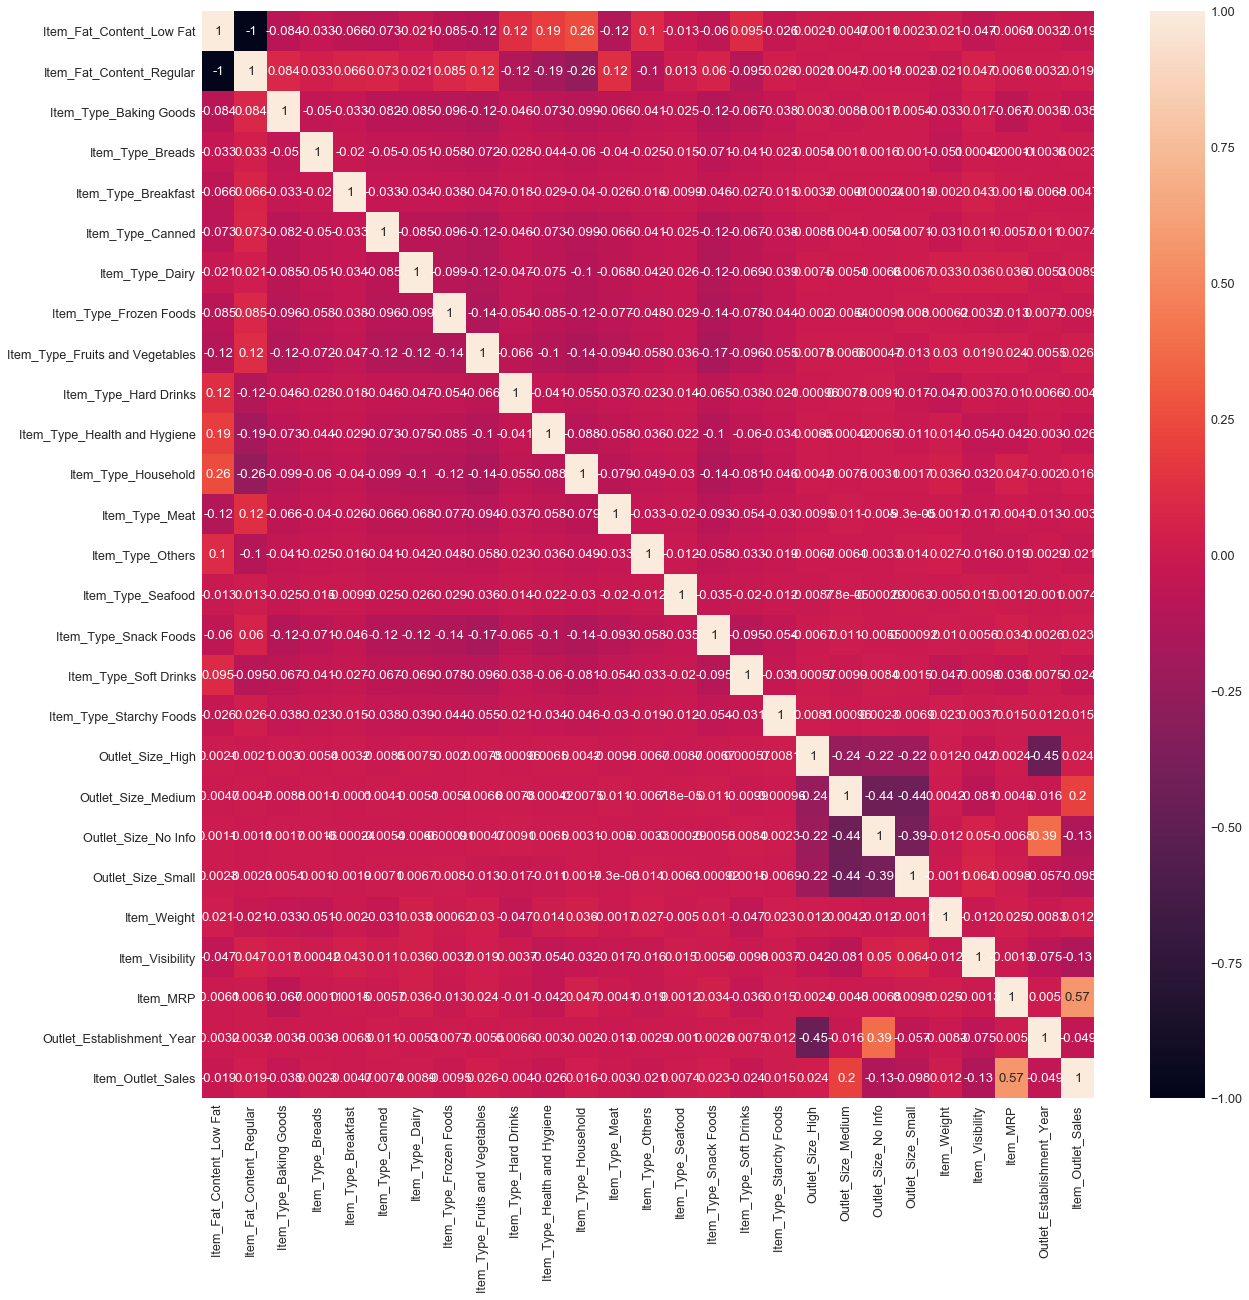

In [135]:
corr = data_reduced.corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)

По матрице видим, что только самые старые магазины имеют размер *High*. Также видим непосредственную зависимость продаж от *Item_MRP*

In [136]:
data_cleaned.groupby(['Outlet_Establishment_Year', 'Outlet_Size']).size()

Outlet_Establishment_Year  Outlet_Size
1985                       Medium         935
                           Small          528
1987                       High           932
1997                       Small          930
1998                       No Info        555
1999                       Medium         930
2002                       No Info        929
2004                       Small          930
2007                       No Info        926
2009                       Medium         928
dtype: int64

**Построение модели**

Оценивать качество полученной модели будем с помощью RMSE, т.к. в силу того, что показатели продаж могут доходить до десятка тысяч, использование квадратичной ошибки приведет к большим выбросам.

**Линейная модель и подбор параметров**

Для построения линейной модели будем использовать *ElasticNet*, для которой будет перебирать максимальное количество итераций *max_iter* для получения оптимального результата.

In [172]:
X_full = data_full.drop(columns=['Item_Outlet_Sales'])
X_reduced = data_reduced.drop(columns=['Item_Outlet_Sales'])
y = data_full['Item_Outlet_Sales']

In [160]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2)

best = (0, 10000000)
for mi in range(10, 1000):
    lin_model = ElasticNet(max_iter=mi)
    lin_model.fit(X_train, y_train)
    y_predict = lin_model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    
    if rmse < best[1]:
        best = (mi, rmse)
    
print(f'\nBest max_iter is {best[0]} with RMSE = {best[1]:.4f}')


Best max_iter is 10 with RMSE = 1242.6021
Wall time: 12.3 s


**Нелинейная модель и подбор параметров**

Для построения нелинейной модели будем использовать *DecisionTreeRegressor*, для которой будет подбирать оптимальную глубину. Подбор глубины осуществляется с использованием *GridSearchCV*

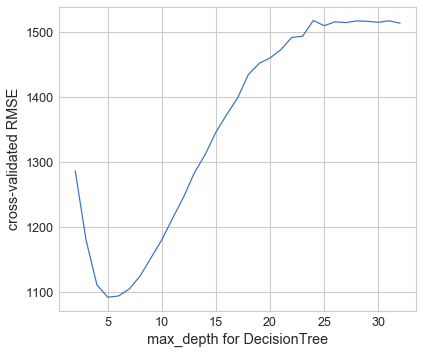

Min depth is 5 for RMSE = 1091.4900


In [164]:
depth = list(range(2, 33))

param_grid = dict(max_depth=depth)

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=10, scoring='neg_root_mean_squared_error')
grid.fit(X_full, y)

mean_scores = np.absolute(grid.cv_results_['mean_test_score'])

plt.plot(depth, mean_scores)
plt.xlabel('max_depth for DecisionTree')
plt.ylabel('cross-validated RMSE')
plt.show()

best_depth, best_rmse = min(zip(depth, mean_scores), key=lambda x: x[1])
print(f'Min depth is {best_depth} for RMSE = {best_rmse:.4f}')

**Стекинг**

В качестве алгоритмов первого уровня будем использовать *KNeighborsRegressor* и *RandomForest*. В качестве алгоритма второго уровня будем использовать ElasticNet

In [184]:
def get_meta_features(reg, X_train, y_train, X_test, y_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        reg.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = reg.predict(X_train.iloc[test_ind])
        meta_test += reg.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=419)

rf_reg = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, n_jobs=-1)
knr_reg = KNeighborsRegressor()
stack_cv = KFold(n_splits=10)

meta_train = []
meta_test = []
col_names = []

meta_tr, meta_te = get_meta_features(knr_reg, X_train, y_train, X_test, y_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knr_pred')

meta_tr, meta_te = get_meta_features(rf_reg, X_train, y_train, X_test, y_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

In [186]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [187]:
enet_reg_meta = ElasticNet()
enet_reg_meta.fit(X_meta_train, y_train)
y_pred_meta_test = enet_reg_meta.predict(X_meta_test)

print(f'RMSE for stacking = {mean_squared_error(y_test, y_pred_meta_test, squared=False):.4f}')

RMSE for stacking = 1091.2119


Значение RMSE получилось почти такое же, как и для нелинейной модели

**Оценка качества модели на отложенной выборке**

Оценим качество модели на отложенных выборках для полного и уменьшенного датасетов с использованием *RandomForestRegressor*

In [193]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=419)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=419)

rf_reg = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, n_jobs=-1)

rf_reg.fit(X_train_full, y_train_full)
y_pred_full = rf_reg.predict(X_test_full)

rf_reg.fit(X_train_reduced, y_train_reduced)
y_pred_reduced = rf_reg.predict(X_test_reduced)

print(f'RMSE for full dataset: {mean_squared_error(y_test_full, y_pred_full, squared=False):.4f}')
print(f'RMSE for reduced dataset: {mean_squared_error(y_test_reduced, y_pred_reduced, squared=False):.4f}')

RMSE for full dataset: 1093.9309
RMSE for reduced dataset: 1181.2341


**Выбор 3 признаков, наиболее влияющих на объем продаж**

Выберем 3 наиболее часто встречающихся признака с использованием кросс-валидации

In [177]:
def rf_cv(X, y):
    rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, n_jobs=-1)
    kf = KFold(n_splits=5)
    
    acc, rec = list(), list()
    for split, (train_i, test_i) in enumerate(kf.split(X)):
        X_train, X_test, y_train, y_test = X.iloc[train_i], X.iloc[test_i], y.iloc[train_i], y.iloc[test_i]
        rf.fit(X_train, y_train)
        y_predict = rf.predict(X_test)
        for feature, imp in sorted(zip(X.columns, rf.feature_importances_), key=lambda im: im[1], reverse=True)[:3]:
            if feature not in feature_imp:
                feature_imp[feature] = 1
            else:
                feature_imp[feature] += 1
    return

In [179]:
feature_imp = dict()
rf_cv(X_full, y)

print('Top 3 features for data_full dataset')
for top, feat in enumerate(list(feature_imp)[:3]):
    print(f'{top+1}. {feat}')

Top 3 features for data_full dataset
1. Item_MRP
2. Outlet_Type_Supermarket
3. Outlet_Establishment_Year


In [181]:
feature_imp = dict()
rf_cv(X_reduced, y)

print('Top 3 features for data_reduced dataset')
for top, feat in enumerate(list(feature_imp)[:3]):
    print(f'{top+1}. {feat}')

Top 3 features for data_reduced dataset
1. Item_MRP
2. Outlet_Establishment_Year
3. Outlet_Size_Medium


## Итоги

В ходе проделанной работы:
- проведен EDA
- обработаны категориальные признаки
- устранены пропущенные значения
- изучена корреляция признаков с данными о продажах
- использована метрика *RMSE* для оценки предсказаний
- построена линейная модель *ElasticNet* с оптимальными параметрами
- построена нелинейная модель *DecisionTreeRegressor* с оптимальными параметрами
- проведен стекинг моделей с *KNeighborsRegressor* и *RandomForestRegressor* в качестве алгоритмов первого уровня и *ElasticNet* в качестве алгоритма второго уровня
- проведена оценка качества модели для полного и усеченного датасетов с использованием RMSE
- выбраны 3 наиболее влияющих на объем продаж признака для полного и усеченного датасетов

Из результатов стекинга можно сделать вывод, что не было необходимости удалять признаки типа магазина и типа локации магазина, т.к. на полных данных результат оказался лучше.

Из корреляционной матрицы, а также согласно наиболее влияющим на объем продаж признакам видно, что наибольшее влияние оказывает признак Item_MRP - максимальная цена продажи продукта.